
   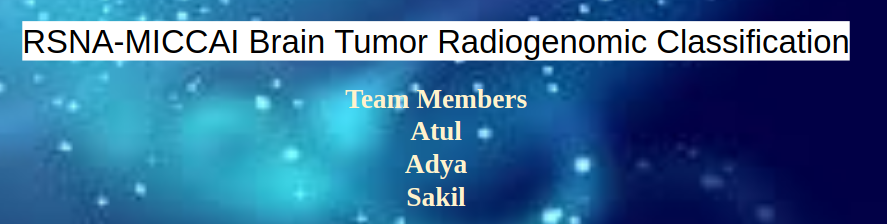

# **Brain Tumor Radiogenomic Classification**

* A malignant tumor in the brain is a life-threatening condition which is known as glioblastoma, it's both the most common form of brain cancer in adults and the one with the worst prognosis, with median survival being less than a year.
* Glioblastoma is a life-threatning brain tumor which is caused by the presence of a specific genetic sequence in the tumor known as MGMT promoter methylation.
* In today's world ,genetic analysis of cancer requires surgery to extract a tissue sample and it can take several weeks to determine the genetic characterization of the tumor.
* Depending upon the results and type of initial therapy chosen, a subsequent surgery may be necessary. 

# **Objective**

* To develope an accurate method in  predicting the genetics of the cancer through imaging which will help in reducing the sugeries required to perform an biopsy to determine if there is a tumor or not. 

# **MRI and Scan Types**

* Magnetic resonance imaging (MRI) is one of the most commonly used tests in neurology and neurosurgery. 
* MRI provides exquisite detail of brain, spinal cord and vascular anatomy, and has the advantage of being able to visualize anatomy in all three planes: axial, sagittal and coronal.
* T1, T2 and FLAIR are different MRI Imaging

# **Different types of Scan**
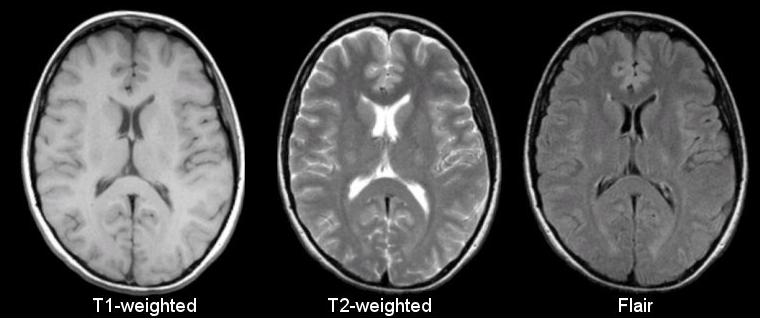

In [ ]:
#for dicom files
!pip install -q pydicom

In [1]:
#importing the necessary libraries
import os
import re 
import glob
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Pydicom related imports
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import tensorflow as tf
# W&B for experiment tracking
import wandb
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
#reading the data
train_data = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
print('Number of records: ', len(train_data))
train_data.head()

Number of records:  585


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


# **Training data Information**

* There are 585 patients and each patient is identified by unique id,BraTS21ID.
* Each patient consists of four structural multi-parametric MRI (mpMRI) scans.They are:
    * Fluid Attenuated Inversion Recovery (FLAIR)
    * T1-weighted pre-contrast (T1w)
    * T1-weighted post-contrast (T1Gd)
    * T2-weighted (T2)
* Each sub-folder contains multiple scans in Dicom format with name - Image-X.dcm where X increases from 1 to N. 
* MGMT_value 1 corresponds to the presence of MGMT promoter and 0 corresponds to absence.

1    307
0    278
Name: MGMT_value, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


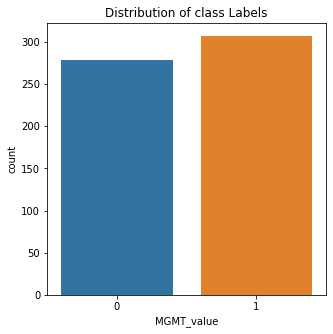

In [41]:
#checking the distribution of the class
plt.figure(figsize=(5, 5))
ax = sns.countplot("MGMT_value",data=train_data)
ax.set_title("Distribution of class Labels");
print(train_data.MGMT_value.value_counts())

# **Analysis**

* The dataset is not entirely balanced.

# **Checking total number of files (.dcm)**

In [4]:
#checking total number of .dcm files
filenames = glob.glob('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/*/*/*')
print(f'Total number of files: {len(filenames)}')

Total number of files: 348641


# **Analysis**

* There are 348641 dcm files

# **Checking the distribution of files based on scan types**

In [5]:
scan_label_dist = {
    'FLAIR': [],
    'T1w': [],
    'T1wCE': [],
    'T2w': []
}

for filename in tqdm(filenames):
    scan = filename.split('/')[-2]
    if scan=='FLAIR':
        scan_label_dist['FLAIR'].append(filename)
    elif scan=='T1w':
        scan_label_dist['T1w'].append(filename)
    elif scan=='T1wCE':
        scan_label_dist['T1wCE'].append(filename)
    else:
        scan_label_dist['T2w'].append(filename)
        
print("Number of files per scan:")
print("<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>")
print("\n")
print('Size of FLAIR scan: {}, T1w scan: {}, T1wCE scan: {}, T2w scan: {}'.format(len(scan_label_dist['FLAIR']), 
                                                                                  len(scan_label_dist['T1w']),
                                                                                  len(scan_label_dist['T1wCE']),
                                                                                  len(scan_label_dist['T2w'])))

100%|██████████| 348641/348641 [00:00<00:00, 774135.91it/s]

Number of files per scan:
<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>


Size of FLAIR scan: 74248, T1w scan: 77627, T1wCE scan: 96766, T2w scan: 100000


# **Analysis**

* There are 74248 FAIR scan
* There are 77627 T1w scan
* There are 96766 T1wCE scan
* There are 100000 T2w scan


In [6]:
CONFIG = {'IMG_SIZE': 224, 
          'competition': 'rsna-miccai-brain', 
          '_wandb_kernel': 'sakil786'}

In [7]:
run = wandb.init(project='brain-tumor-viz', config=CONFIG)
data = [['FLAIR', 74248], ['T1w', 77627], ['T1wCE', 96766], ['T2w', 100000]]
table = wandb.Table(data=data, columns = ["Scan Type", "Num Files"])
wandb.log({"my_bar_chart_id" : wandb.plot.bar(table, "Scan Type", "Num Files",
                               title="Scan Types vs Number of Dicom files")})
run.finish()

wandb: Currently logged in as: sakil786 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


_runtime,6
_timestamp,1627568351
_step,0


_runtime,▁
_timestamp,▁
_step,▁


# Barchart for different types of Scan



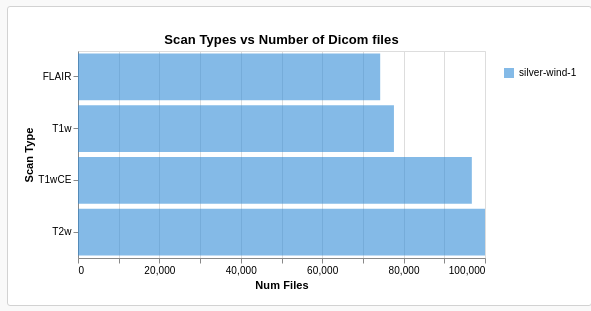

# **Reading DICOM File**

In [8]:

def dicomFileTransformation(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

# **Note**
* MONOCHROME1 indicates that the greyscale ranges from bright to dark with ascending pixel values
*  MONOCHROME2 ranges from dark to bright with ascending pixel values.
* The Value Of Interest(VOI) LUT transformation transforms the modality pixel values into pixel values which are meaningful for the user or the application. 


Shape of data:  (512, 512)


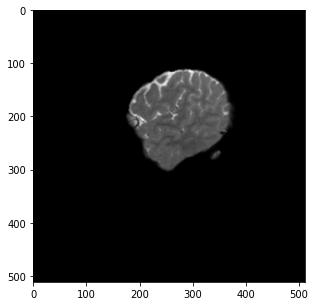

In [9]:
data = dicomFileTransformation(filenames[16])
print('Shape of data: ', data.shape)

plt.figure(figsize=(5, 5))
plt.imshow(data, cmap='gray');

# **Analysis**

* Each MRI image has a resolution of 512x512 pixels.

In [17]:
patient_ids = os.listdir('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train')
IDX = np.random.choice(len(patient_ids))

patient_id = patient_ids[IDX]
print(f'Patient ID: {patient_id}')

Patient ID: 00369


In [18]:
def sorted_nicely(l): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [19]:
#checking the number of images per patient id
flair_data = []
flair_filenames = os.listdir(f'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{patient_id}/FLAIR/')
flair_filenames = sorted_nicely(flair_filenames)
for filename in flair_filenames:
    flair_data.append(dicomFileTransformation(f'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{patient_id}/FLAIR/{filename}'))
    
print(f'Number of FLAIR images for the patient: {len(flair_data)}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Number of FLAIR images for the patient: 60


In [20]:
run = wandb.init(project='brain-tumor-viz', config=CONFIG)
wandb.log({f"flair_{patient_id}": [wandb.Image(image) for image in flair_data]})
run.finish()

wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


_runtime,7
_timestamp,1627568837
_step,0


_runtime,▁
_timestamp,▁
_step,▁


In [21]:
#copying the data
train=train_data.copy()

In [22]:
#adding imfolder in the dataframe
train["imfolder"] = ['{0:05d}'.format(s) for s in train["BraTS21ID"]]
train.head(100)

,BraTS21ID,MGMT_value,imfolder
0,0,1,00000
1,2,1,00002
2,3,0,00003
3,5,1,00005
4,6,1,00006
...,...,...,...
95,144,1,00144
96,146,1,00146
97,147,0,00147
98,148,0,00148


In [23]:
#adding the path in the dataframe
train_path = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/train"

train["path"] = [os.path.join(train_path,s) for s in train["imfolder"]  ]
train.head()

,BraTS21ID,MGMT_value,imfolder,path
0,0,1,00000,../input/rsna-miccai-brain-tumor-radiogenomic-...
1,2,1,00002,../input/rsna-miccai-brain-tumor-radiogenomic-...
2,3,0,00003,../input/rsna-miccai-brain-tumor-radiogenomic-...
3,5,1,00005,../input/rsna-miccai-brain-tumor-radiogenomic-...
4,6,1,00006,../input/rsna-miccai-brain-tumor-radiogenomic-...


In [24]:
scans_label = ["FLAIR","T1w","T1wCE","T2w"]

In [25]:
#counting the number of dcm files per patient
for scan in scans_label:
    train[scan +"_count"] = [ len(os.listdir(os.path.join(train["path"].iloc[s],scan))) for s in tqdm(range(len(train))) ]

100%|██████████| 585/585 [00:00<00:00, 2029.67it/s]


In [26]:
train.head()

,BraTS21ID,MGMT_value,imfolder,path,FLAIR_count,T1w_count,T1wCE_count,T2w_count
0,0,1,00000,../input/rsna-miccai-brain-tumor-radiogenomic-...,400,33,129,408
1,2,1,00002,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,31,129,384
2,3,0,00003,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,33,129,408
3,5,1,00005,../input/rsna-miccai-brain-tumor-radiogenomic-...,400,28,129,424
4,6,1,00006,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,32,129,408


In [27]:
train.shape

(585, 8)

In [28]:
#checking which patient has same files in all types of scans
allsame_column = [train["FLAIR_count"].iloc[s] ==   train["T1w_count"].iloc[s] ==train["T1wCE_count"].iloc[s] ==train["T2w_count"].iloc[s] 
          for s in range(len(train))]

In [29]:
train["allsame_column"] = allsame_column
train

,BraTS21ID,MGMT_value,imfolder,path,FLAIR_count,T1w_count,T1wCE_count,T2w_count,allsame_column
0,0,1,00000,../input/rsna-miccai-brain-tumor-radiogenomic-...,400,33,129,408,False
1,2,1,00002,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,31,129,384,False
2,3,0,00003,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,33,129,408,False
3,5,1,00005,../input/rsna-miccai-brain-tumor-radiogenomic-...,400,28,129,424,False
4,6,1,00006,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,32,129,408,False
...,...,...,...,...,...,...,...,...,...
580,1005,1,01005,../input/rsna-miccai-brain-tumor-radiogenomic-...,23,23,23,23,True
581,1007,1,01007,../input/rsna-miccai-brain-tumor-radiogenomic-...,124,124,124,124,True
582,1008,1,01008,../input/rsna-miccai-brain-tumor-radiogenomic-...,60,192,192,64,False
583,1009,0,01009,../input/rsna-miccai-brain-tumor-radiogenomic-...,23,23,23,23,True


In [30]:
train["allsame_column"].sum()

63

# **Analysis**

* 63 patients have same number of dcm files in all scan

In [31]:
#checking the percentage of same dcm files
train["allsame_column"].sum()/len(train) * 100

10.76923076923077

In [32]:
#printing same dcm files
train[train["allsame_column"]]

,BraTS21ID,MGMT_value,imfolder,path,FLAIR_count,T1w_count,T1wCE_count,T2w_count,allsame_column
64,100,1,00100,../input/rsna-miccai-brain-tumor-radiogenomic-...,22,22,22,22,True
65,102,0,00102,../input/rsna-miccai-brain-tumor-radiogenomic-...,23,23,23,23,True
68,106,1,00106,../input/rsna-miccai-brain-tumor-radiogenomic-...,28,28,28,28,True
74,112,0,00112,../input/rsna-miccai-brain-tumor-radiogenomic-...,24,24,24,24,True
75,113,0,00113,../input/rsna-miccai-brain-tumor-radiogenomic-...,23,23,23,23,True
...,...,...,...,...,...,...,...,...,...
577,1002,1,01002,../input/rsna-miccai-brain-tumor-radiogenomic-...,24,24,24,24,True
578,1003,1,01003,../input/rsna-miccai-brain-tumor-radiogenomic-...,23,23,23,23,True
580,1005,1,01005,../input/rsna-miccai-brain-tumor-radiogenomic-...,23,23,23,23,True
581,1007,1,01007,../input/rsna-miccai-brain-tumor-radiogenomic-...,124,124,124,124,True


In [33]:
def makepath(row_ID,scan):
    """ Function to keep all categories files in their respective path""" 
    temp_folder = train["path"].iloc[row_ID]
    temp_folder2 = os.path.join(temp_folder,scan)
    temp_files = os.listdir(temp_folder2)
    imagenum = [s.split("-")[1] for s in temp_files]
    imagenum = [s.split(".")[0] for s in imagenum]
    temp_path = [os.path.join(temp_folder2,s) for s in temp_files]
    tempdf = pd.DataFrame()
    tempdf["image_num"] = imagenum
    tempdf["image_num"] = tempdf["image_num"].astype("int")
    tempdf["temp_path"] = temp_path
    tempdf = tempdf.sort_values("image_num").reset_index(drop=True)
    finpath = tempdf["temp_path"]
    return finpath

In [34]:
scans_label = ["FLAIR","T1w","T1wCE","T2w"]

In [35]:
row_id=64

sampledf = pd.DataFrame()
for scan in scans_label:
    sampledf[scan + "_path"] = makepath(row_id,scan)

In [36]:
sampledf.head(3)


,FLAIR_path,T1w_path,T1wCE_path,T2w_path
0,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
2,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...


In [37]:
sampledf['FLAIR_path'].head()

0    ../input/rsna-miccai-brain-tumor-radiogenomic-...
1    ../input/rsna-miccai-brain-tumor-radiogenomic-...
2    ../input/rsna-miccai-brain-tumor-radiogenomic-...
3    ../input/rsna-miccai-brain-tumor-radiogenomic-...
4    ../input/rsna-miccai-brain-tumor-radiogenomic-...
Name: FLAIR_path, dtype: object

In [38]:
def makeimg(path):
    dataset = pydicom.filereader.dcmread(path)
    img = dataset.pixel_array
    return img

MGMT_value = 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


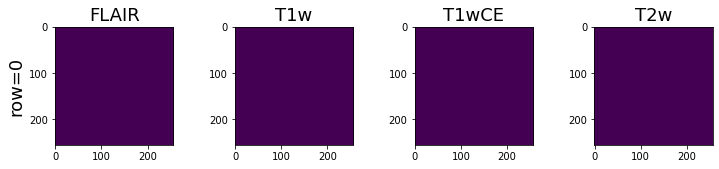

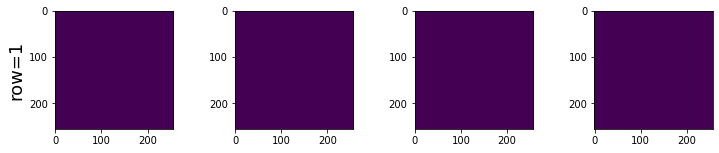

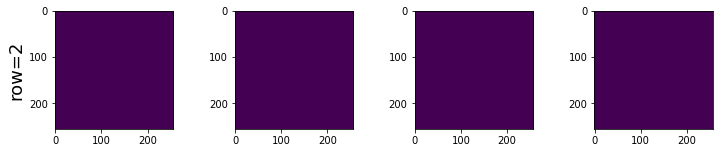

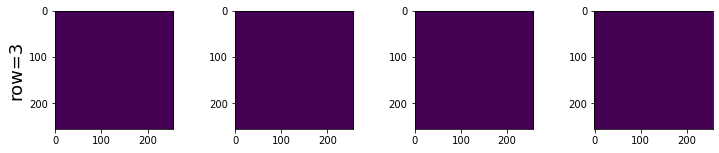

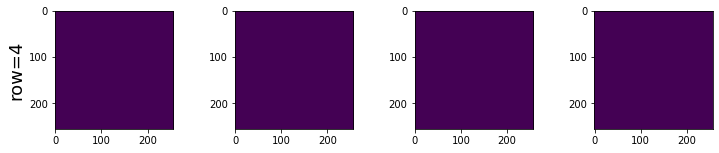

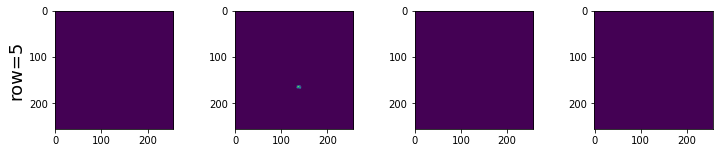

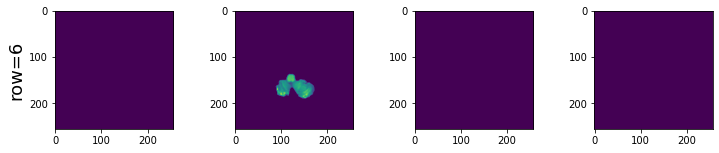

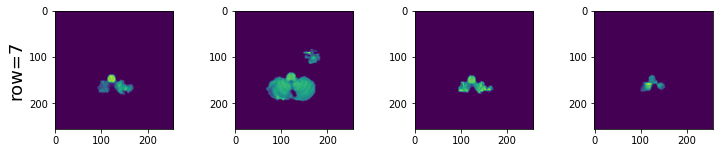

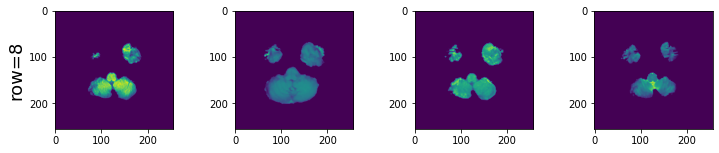

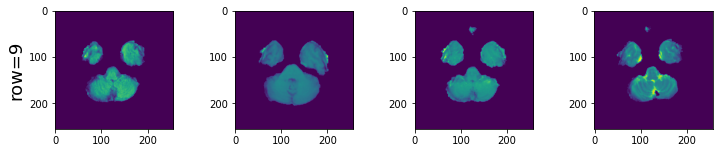

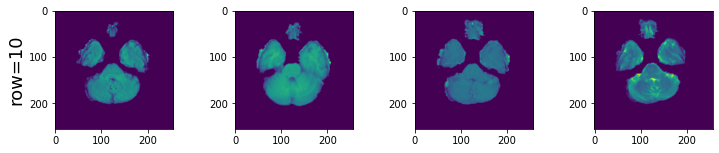

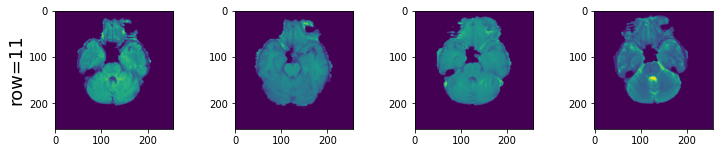

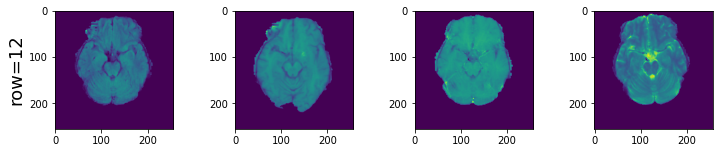

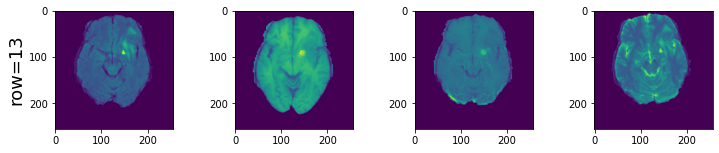

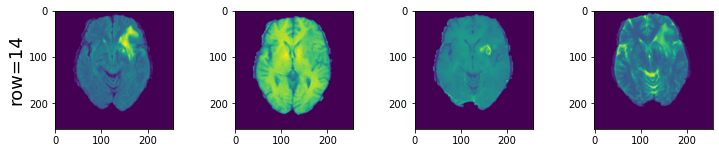

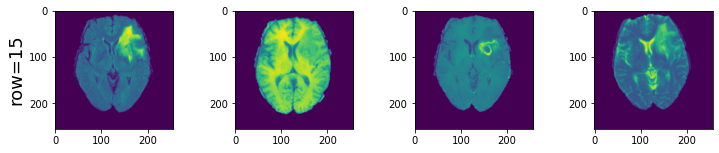

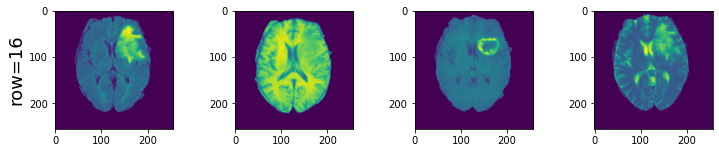

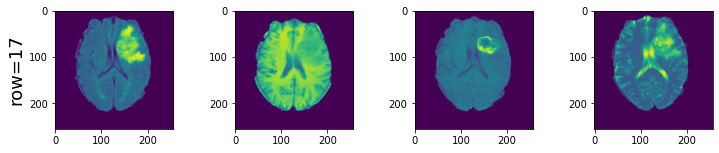

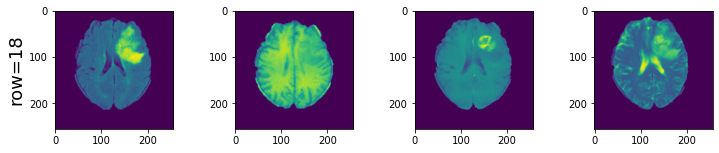

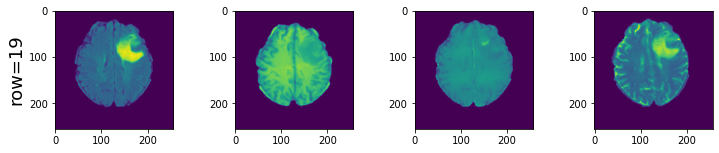

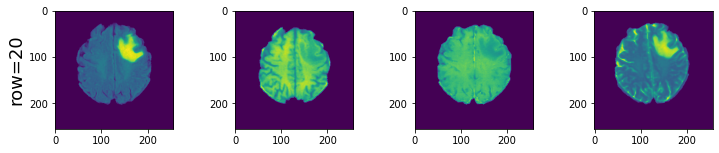

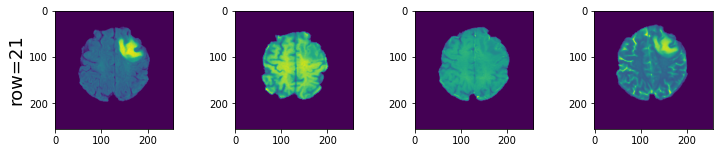

In [39]:
print("MGMT_value = " + str(train["MGMT_value"].iloc[row_id]))

#showing the scans for patient_id=100 and row_id=64 ,whose MGMT_value=1
for row in range(len(sampledf)):
    plt.figure(figsize=(80,10))
    for num,scan in enumerate(scans_label):
        img = makeimg(sampledf[scan + "_path"].iloc[row])
        plt.subplot(4,25,num+1)
        #plt.axis("off")
        plt.imshow(img)
        
        if row==0:
            plt.title(scan,fontsize=18)
        if num==0:
            plt.ylabel("row=" + str(row),fontsize=18)

# **Analysis**
* There are 22 dcm files for the patient_id 100 whose MGMT_value=1

MGMT_value = 0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


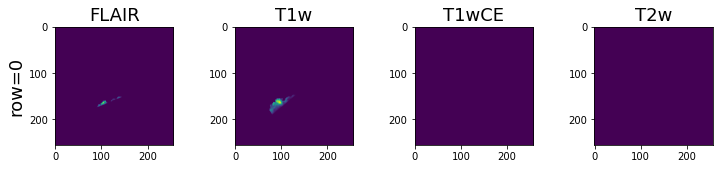

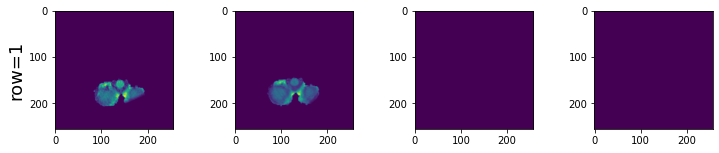

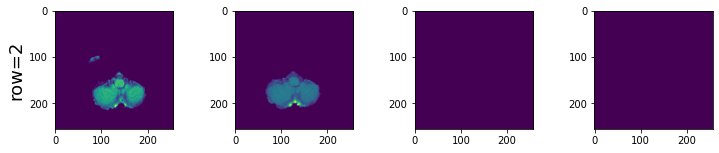

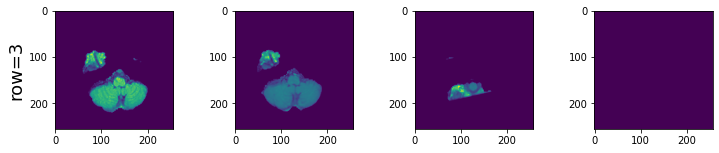

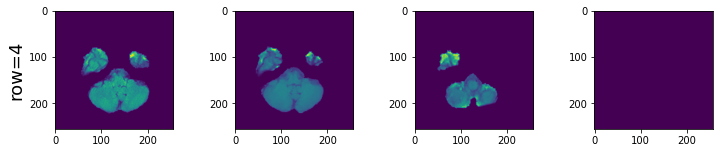

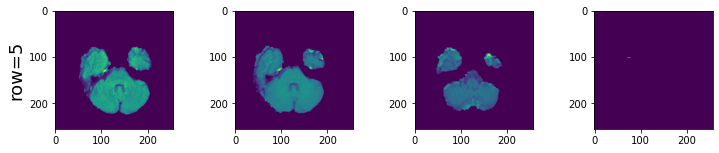

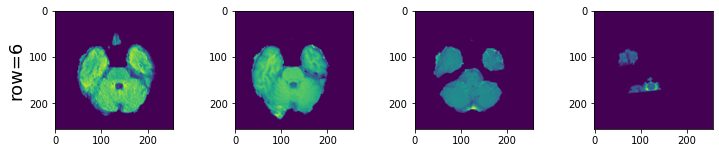

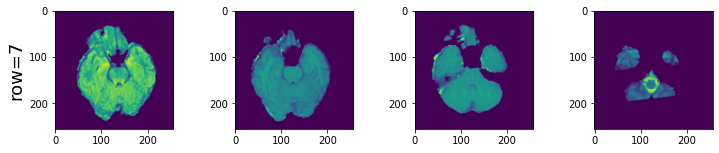

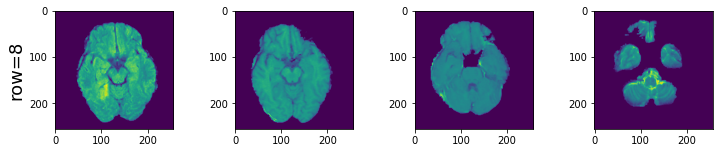

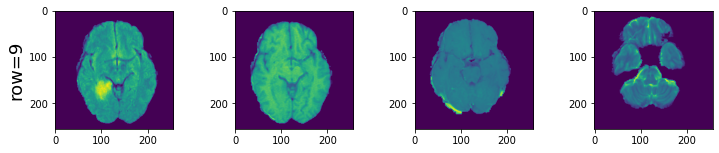

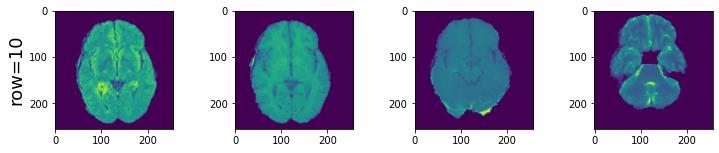

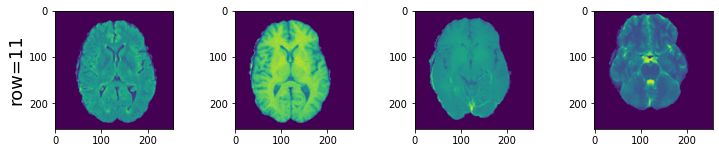

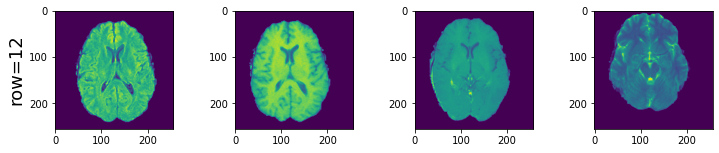

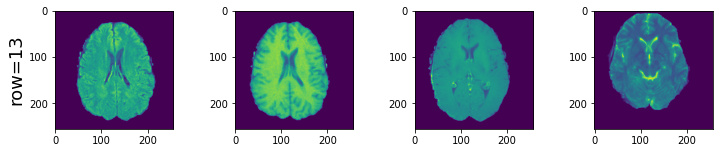

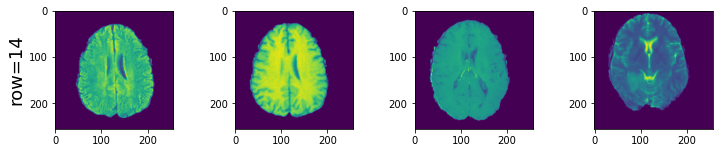

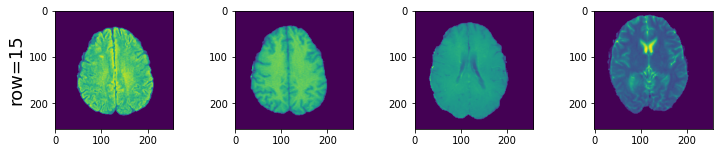

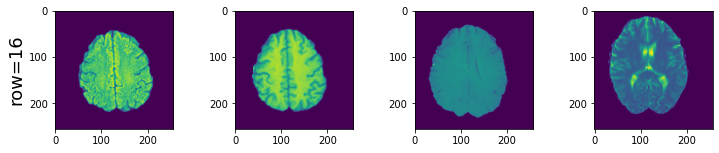

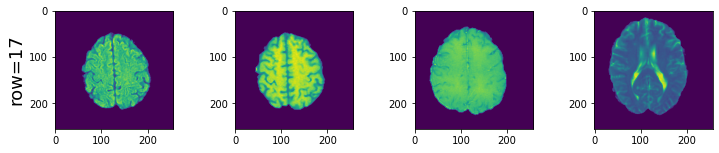

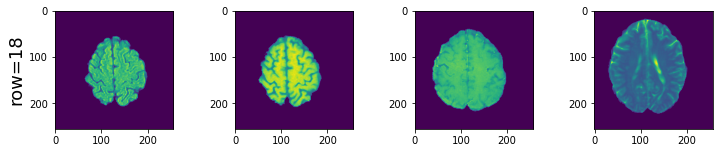

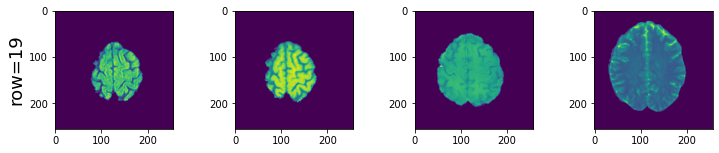

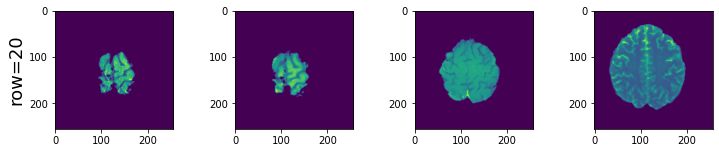

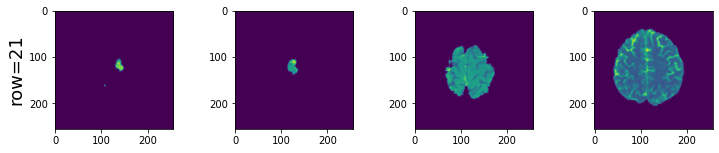

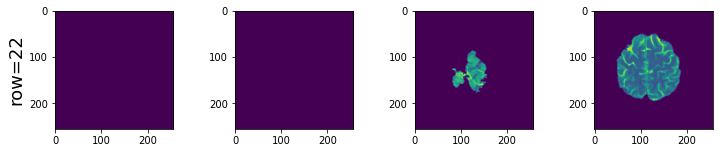

In [40]:
row_id = 65

sampledf = pd.DataFrame()
for scan in scans_label:
    sampledf[scan + "_path"] = makepath(row_id,scan)
#showing the scans for patient_id=100 and row_id=65 ,whose MGMT_value=0
print("MGMT_value = " + str(train["MGMT_value"].iloc[row_id]))

for row in range(len(sampledf)):
    plt.figure(figsize=(80,10))
    for num,scan in enumerate(scans_label):
        img = makeimg(sampledf[scan + "_path"].iloc[row])
        plt.subplot(4,25,num+1)
        #plt.axis("off")
        plt.imshow(img)
        
        if row==0:
            plt.title(scan,fontsize=18)
        if num==0:
            plt.ylabel("row=" + str(row),fontsize=18)



# **Analysis**
* There are 23 dcm files for the patient_id 102 whose MGMT_value=0